In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../..")

from gob.benchmarks import *
from gob.optimizers import *
import matplotlib
matplotlib.rcParams.update({"text.usetex": True})

In [2]:
class MinWrapper:
  def __init__(self, func):
    self.func = func
    self.visual_bounds = func.visual_bounds
    self.values = []
  
  def __call__(self, x):
    y = self.func(x)
    self.values.append(y)
    return y
  
  def get_min_per_iteration(self, n_particles):
    mins = []
    for i in range(len(self.values) // n_particles):
      prev_min = mins[-1] if mins else float("inf")
      actual_min = np.min(self.values[i * n_particles : (i + 1) * n_particles])
      mins.append(min(prev_min, actual_min))
    return mins

class MinWrapperGrad:
  def __init__(self, func):
    self.func = func
    self.visual_bounds = func.visual_bounds
    self.values = []
    self.prev_sample = None
  
  def __call__(self, x):
    y = self.func(x)
    if self.prev_sample is None or not np.all(np.abs(x - self.prev_sample) <= 2e-9):
      self.values.append(y)
    self.prev_sample = x
    return y
  
  def get_min_per_iteration(self, n_particles):
    mins = []
    for i in range(len(self.values) // n_particles):
      prev_min = mins[-1] if mins else float("inf")
      actual_min = np.min(self.values[i * n_particles : (i + 1) * n_particles])
      mins.append(min(prev_min, actual_min))
    return mins

In [3]:
def format_results(res):
  for i in range(len(res)):
    if len(res[i]) < iter:
      print(f"Run {i} of mins has length {len(res[i])} instead of {iter}")
      # Copy the last value to extend the length
      last_value = res[i][-1]
      res[i] = list(res[i]) + [last_value] * (iter - len(res[i]))

In [4]:
g = Ackley()
dim = 4
bounds = augment_dimensions(g.visual_bounds, dim)
n_particles = 30
iter = 800
verbose = False
n_runs = 5
independent_noise = True
wrapper = MinWrapper
alg = CBO
cn_alg = lambda moment: SMD_CBO(bounds=bounds, n_particles=n_particles, iter=iter, moment=moment, verbose=verbose)

In [13]:
mins = []
for i in range(n_runs):
  f = wrapper(g)

  opt = alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose)
  res = opt.minimize(f)
  print(f"Results for {opt} on {g}: {res[1]}")
  mins.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins)
mins = np.array(mins)

Results for CBO on Ackley: 20.082214017981666
Results for CBO on Ackley: 20.267653835419697
Results for CBO on Ackley: 20.136914717305267
Results for CBO on Ackley: 19.915769195114887
Results for CBO on Ackley: 18.955769026901038


In [6]:
mins_m1 = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg("M1")
  res = opt.minimize(f)
  print(f"Results for {opt} on {g}: {res[1]}")
  mins_m1.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_m1)
mins_m1 = np.array(mins_m1)

Results for SMD-CBO on Ackley: 15.379611946078711
Results for SMD-CBO on Ackley: 15.33293196934294
Results for SMD-CBO on Ackley: 16.657155824565532
Results for SMD-CBO on Ackley: 16.851047921352517
Results for SMD-CBO on Ackley: 16.809294790481164


In [7]:
mins_m2 = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg("M2")
  res = opt.minimize(f)
  print(f"Results for {opt} on {g}: {res[1]}")
  mins_m2.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_m2)
mins_m2 = np.array(mins_m2)

Results for SMD-CBO on Ackley: 19.814307710565718
Results for SMD-CBO on Ackley: 17.551290012765957
Results for SMD-CBO on Ackley: 20.12043363489111
Results for SMD-CBO on Ackley: 19.078515555743607
Results for SMD-CBO on Ackley: 18.946566504834774


In [8]:
mins_var = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg("VAR")
  res = opt.minimize(f)
  print(f"Results for {opt} on {g}: {res[1]}")
  mins_var.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_var)
mins_var = np.array(mins_var)

Results for SMD-CBO on Ackley: 19.308121309665463
Results for SMD-CBO on Ackley: 19.969132416365984
Results for SMD-CBO on Ackley: 18.812061907706774
Results for SMD-CBO on Ackley: 20.18851924040606
Results for SMD-CBO on Ackley: 18.293378605699925


In [19]:
mins_mvar = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg("MVAR")
  res = opt.minimize(f)
  print(f"Results for {opt} on {g}: {res[1]}")
  mins_mvar.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_mvar)
mins_mvar = np.array(mins_mvar)

Results for SMD-CBO on Ackley: 15.06440433742478
Results for SMD-CBO on Ackley: 17.712129464381174
Results for SMD-CBO on Ackley: 16.1932867385209
Results for SMD-CBO on Ackley: 19.206149930412565
Results for SMD-CBO on Ackley: 15.425683652563958


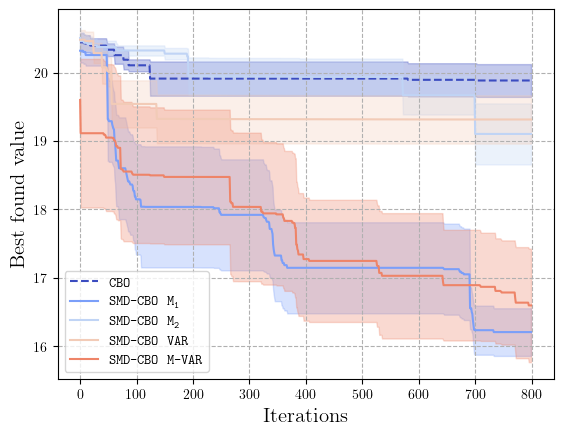

In [20]:
alg_name = str(alg([]))
cn_alg_name = str(cn_alg("M1"))

latex_label = lambda s: r"\texttt{" + s.replace("_", r"\_") + "}"

cmap = matplotlib.colormaps["coolwarm"]

c0 = cmap(0)
c1 = cmap(0.2)
c2 = cmap(0.4)
c3 = cmap(0.6)
c4 = cmap(0.8)

coeff = 2

mean = mins.mean(axis=0)
std = mins.std(axis=0)
plt.plot(mean, label=latex_label(alg_name), linestyle="--", color=c0)
plt.fill_between(range(iter), mean - (std / coeff), mean + (std / coeff), alpha=0.3, color=c0)

mean = mins_m1.mean(axis=0)
std = mins_m1.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M" + r"\textsubscript{1}"), linestyle="-", c=c1)
plt.fill_between(range(len(mean)), mean - (std / coeff), mean + (std / coeff), alpha=0.3, color=c1)

mean = mins_m2.mean(axis=0)
std = mins_m2.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M" + r"\textsubscript{2}"), linestyle="-", c=c2)
plt.fill_between(range(iter), mean - (std / coeff), mean + (std / coeff), alpha=0.3, color=c2)

mean = mins_var.mean(axis=0)
std = mins_var.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} VAR"), linestyle="-", c=c3)
plt.fill_between(range(iter), mean - (std / coeff), mean + (std / coeff), alpha=0.3, color=c3)

mean = mins_mvar.mean(axis=0)
std = mins_mvar.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M-VAR"), linestyle="-", c=c4)
plt.fill_between(range(iter), mean - (std / coeff), mean + (std / coeff), alpha=0.3, color=c4)

plt.xlabel(r"$\textrm{Iterations}$", fontsize=15)
plt.ylabel(r"$\textrm{Best found value}$", fontsize=15)
plt.grid(linestyle="--")
plt.legend()

in_status = "IN" if independent_noise else "no_IN"
plt.savefig(f"impact_noise_{alg_name.lower()}_{in_status}_{g}.pdf", bbox_inches="tight")